# Interpretation 3B: KAN Compiler for hidden variables


We have always assumed that the input and output variables are physical variables, but this might not be the case for raw data. For example, when we are given an image of a Gaussian bump, what's physical is the x and y coordinates of the Gaussian bump center, but the raw data is the pixels of the image. So we want to learn a physical parameter extractor that transforms images to physical parameters, and then perform some computations on the physical parameters to make the prediction.

construct dataset 

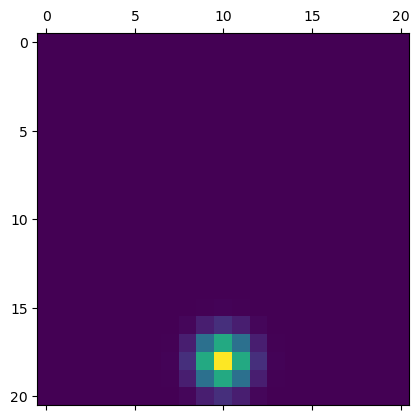

In [101]:
import torch
import matplotlib.pyplot as plt
import numpy as np

sigma = 0.1
x0 = 0.8
y0 = 0.
N_pixel = 21

x = y = torch.linspace(-1,1,steps=N_pixel)
X, Y = torch.meshgrid(x, y)
Z = 1/sigma * torch.exp(-((X-x0)**2+(Y-y0)**2)/(2*sigma**2)).detach().numpy()
plt.matshow(Z)

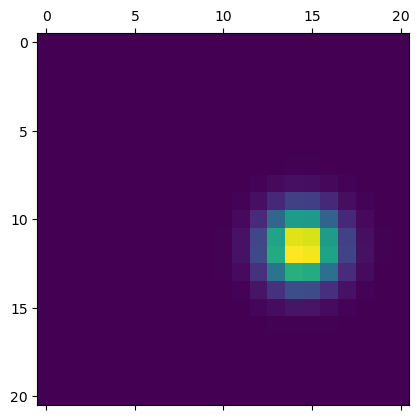

In [102]:
n_sample = 10000
x0 = torch.rand(n_sample,) * 1.2 - 0.6
y0 = torch.rand(n_sample,) * 1.2 - 0.6
sigma = torch.rand(n_sample,) * 0.2 + 0.1
x0 = x0[:, None, None]
y0 = y0[:, None, None]
sigma = sigma[:, None, None]

x = y = torch.linspace(-1,1,steps=N_pixel)
X, Y = torch.meshgrid(x, y)
X = X[None, :, :]
Y = Y[None, :, :]

Z = 1/sigma * torch.exp(-((X-x0)**2+(Y-y0)**2)/(2*sigma**2))
plt.matshow(Z[9,:,:])

In [103]:
inputs = Z.reshape(n_sample, -1)
labels = (torch.sin(torch.pi*x0)+y0**2)[:,:,0]

num = inputs.shape[0]
ratio = 0.8
train_num = int(num*ratio)
train_id = np.random.choice(num, train_num, replace=False)
test_id = list(set(range(num)) - set(train_id))

dataset = {}
dataset['train_input'] = inputs[train_id]
dataset['test_input'] = inputs[test_id]
dataset['train_label'] = labels[train_id]
dataset['test_label'] = labels[test_id]

saving model version 0.1


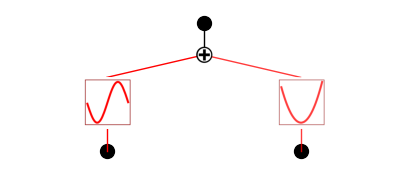

In [104]:
from kan import *
from kan.models import AutoEncoder
from kan.compiler import kanpiler
from sympy import *
from kan.utils import create_dataset
import torch

input_variables = x,y = symbols('x y')
expr = sin(pi*x)+y**2 #+ 0.01 * sin(2*pi*x) * sin(2*pi*y)

decoder = kanpiler(input_variables, expr, grid=5)

x = torch.rand(100,2) * 2 - 1
decoder.get_act(x)

#decoder.symbolic_fun[0].affine.requires_grad_(False)
#decoder.symbolic_fun[1].affine.requires_grad_(False)

decoder.plot()

In [105]:
model = AutoEncoder(enc_type='mlp', dec_type='kan', width_enc=[N_pixel**2,10,2], width_dec=decoder.width)
model.decoder = decoder

checkpoint directory created: ./model
saving model version 0.0


In [106]:
model.fit(dataset, steps=100)

| train_loss: 2.13e-02 | test_loss: 2.49e-02 | reg: 1.82e+02 | : 100%|█| 100/100 [01:47<00:00,  1.07

saving model version 0.1


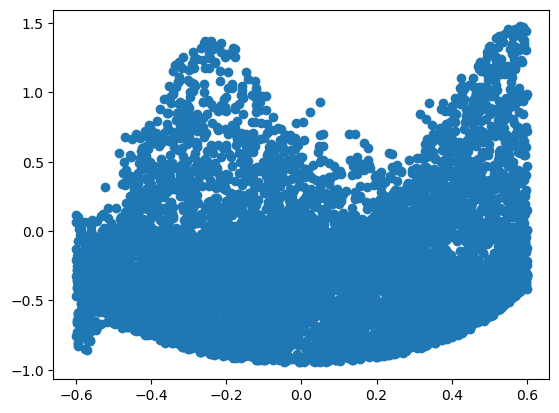

In [107]:
plt.scatter(y0[train_id], model.encoder(dataset['train_input'])[:,1].detach().numpy())

In [97]:
weight = model.encoder.linears[0].weight

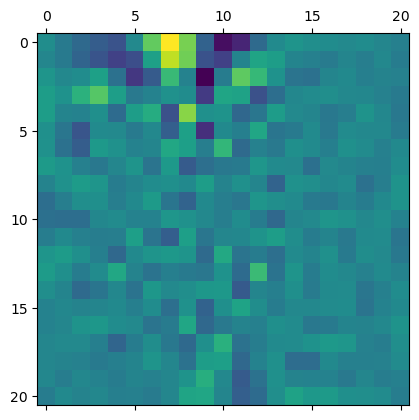

In [98]:
plt.matshow(weight[0].reshape(N_pixel,N_pixel).detach().numpy())

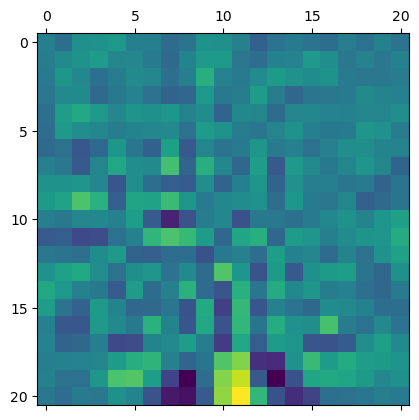

In [99]:
plt.matshow(weight[1].reshape(N_pixel,N_pixel).detach().numpy())

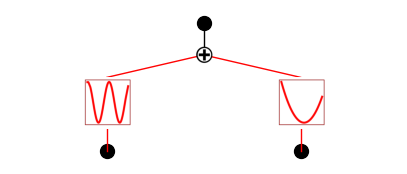

In [100]:
decoder.plot()